In [1]:
from transformers import pipeline, AutoConfig, GPT2LMHeadModel, GPT2Tokenizer
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.utils
import sklearn.model_selection
import sklearn.metrics

2022-05-16 00:05:34.069165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 00:05:34.069198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
with open('data_train.p', 'rb') as f:
    data_train = pickle.load(f)

In [16]:
data = np.load('dataset.npz')
X = data['X']
y = data['y']

In [4]:
class SemanticTypeAnalyzer:
    
    def __init__(self, data_train):
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt2.config.max_length = 1024
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.generator = pipeline("text-generation", model=self.gpt2, tokenizer=self.tokenizer)
        
        self.data_train = data_train
        self.classes = list(data_train.keys())
        self.classes_text = list(map(lambda x: x.split('_')[-1], self.classes))
        
    def generate_prompt(self, phrase, n_examples=15):
        prompt = ''
        for i in range(n_examples):
            cls_idx = np.random.randint(0, len(self.classes))
            cls_name_prompt = self.classes_text[cls_idx]
            cls_name = self.classes[cls_idx]
            sample_idx = np.random.randint(0, len(self.data_train[cls_name]))
            sample = self.data_train[cls_name][sample_idx]
            prompt += f'Assign this phrase one of the five types {", ".join(self.classes_text)}:\n'
            prompt += f'"{sample}"\nType: {cls_name_prompt}\n\n'
        prompt += f'"{phrase}"\nType:'
        return prompt

    def evaluate_prompt(self, prompt, n_samples=5):
        len_prompt = len(prompt)
        len_answer = len(self.tokenizer(prompt).input_ids) + 5
        res = self.generator(prompt, max_length=len_answer, num_return_sequences=n_samples)
        return list(map(lambda x: x['generated_text'][len_prompt:].split('\n')[0].replace(' ', ''), res))
    
    def predict_claim(self, claim, n_prompts=10, n_samples=5):
        preds = []
        for _ in range(n_prompts):
            prompt = self.generate_prompt(claim)
            preds += self.evaluate_prompt(prompt, n_samples=n_samples)

        results = {}
        for cls in self.classes_text:
            results[cls] = preds.count(cls)
        results['other_text'] = list(filter(lambda x: x not in self.classes_text, preds))
        results['other'] = len(results['other_text'])
        return results
    
    def predict_probas(self, claim, n_prompts=10, n_samples=5):
        res = self.predict_claim(claim, n_prompts=n_prompts, n_samples=n_samples)
        probas = np.zeros(len(self.classes_text))
        for i, cls in enumerate(self.classes_text):
            probas[i] = res[cls]
        probas /= np.sum(probas)
        return probas
        
    def predict(self, X, n_prompts=10, n_samples=5):
        probas = np.array(list(map(lambda x: self.predict_probas(x, n_prompts=n_prompts, n_samples=n_samples), X)))
        return probas#np.argmax(probas, axis=1)

In [5]:
analyzer = SemanticTypeAnalyzer(data_train)

## Experiments

In [ ]:
X, y = sk.utils.shuffle(X, y)

In [6]:
X_small, _, y_small, _ = sk.model_selection.train_test_split(X, y, train_size=2)

In [7]:
probas = analyzer.predict(X_small)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [10]:
preds = np.argmax(probas, axis=1)

In [11]:
preds_posterior = np.argmax(probas * np.array([461., 624., 339.,  95.,  72.]), axis=1)

In [12]:
y_small

array([1., 1.])

In [13]:
preds

array([0, 3])

In [14]:
print(sk.metrics.classification_report(y_small, preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00       2.0
         3.0       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/home/jonas/.miniconda3/envs/39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonas/.miniconda3/envs/39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonas/.miniconda3/envs/39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonas/

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (5).

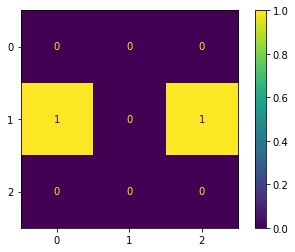

In [15]:
sk.metrics.ConfusionMatrixDisplay.from_predictions(y_small, preds, display_labels=data_train.keys(), xticks_rotation=45)
plt.savefig('confusion.png', bbox_inches='tight')

In [ ]:
print(sk.metrics.classification_report(y_small, preds_posterior))

In [ ]:
sk.metrics.ConfusionMatrixDisplay.from_predictions(y_small, preds_posterior)